# ECBM E4040: Assignment 1, Task 1 - Basic ML Classifiers

In this task, you are going to implement two classifers and apply them to the  CIFAR-10 dataset: 

(1) Linear SVM classifier, and

(2) Softmax classifier.

In [1]:
# Import modules, make sure you have installed all required packages before you start.
import os
import pickle
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load CIFAR-10 data

CIFAR-10 is a widely used dataset which contains 60,000 color images of size 32x32 divided into 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. We are going to use them to create our training set, validation set and test set.

See https://www.cs.toronto.edu/~kriz/cifar.html. 

In [2]:
# Load the raw CIFAR-10 data. You can learn about how to use CIFAR dataset by studing cifar_utils code,
# but you don't need to worry about that when doing this task.
X_train, y_train, X_test, y_test = load_data()

# We have vectorized the data (rearranged the storage of images) for you. 
# That is, we flattened 1×32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 color channels.
# The reason we do this is because we can not put 3-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML model). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs in later assignments.

# Check the results
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)


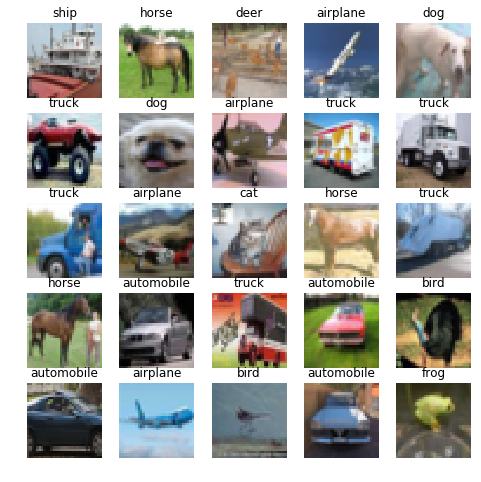

In [3]:
# This part will walk you through how to visualize the CIFAR-10 train dataset.
# We first find names of 10 categories.
f = open('data/cifar-10-batches-py/batches.meta', 'rb')
namedict = pickle.load(f, encoding='latin1')
f.close()
category = namedict['label_names']
# We then reshape vectorized data into the image format
X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

print(category)
print(X.shape)

#Visualizing CIFAR 10 data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        axes1[j][k].set_title(category[y_train[i]])

In [4]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
Development data shape: (100, 3072)
Development data shape (100,)


In [5]:
# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (100, 3073)


## Part 1: Linear Support Vector Machine (SVM) Classifier

In this part, you are going to implement a linear SVM classifier. 

Excellent summaries of SVM methods are presented in ([John Paisley, "Machine Learning for Data Science," SVM_slides](http://www.columbia.edu/~jwp2128/Teaching/W4721/Spring2017/slides/lecture_2-23-17.pdf)) and ([David Sontag, "Introduction to Machine Learning,", New York University, Lectures 4,5,6 ](http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture4.pdf)).

**Brief introduction to SVM**

Support Vector Mahcine (SVM) is a very important supervised classification model developed in 1992. ([Original paper by Boser et al.](http://dl.acm.org/citation.cfm?id=130401)). It can be used not only for binary classification problems, but also for multiclass classification. As our course reference books points out:
> One key innovation associated with support vector machines is the _kernel tricks_.

SVM is a __max margin classifier__ that tries to maximize the __margin__ between clusters of data points. The __margin__ between a boundary hyperplane and a cluster is defined as the minimal distance from the points inside the cluster to the boundary. Intuitively speaking, the classification boundary should be as far away from any cluster as possible. 

![classifier_graph](./img/SVM1.png)

The picture above shows what a SVM boundary could look like, in a 2-D plane. Notice that in the left image, the boundary is good enough to distinguish the 2 clusters, but the margins are small (at least one point from a cluster is very close to the boundary). In the image on the right, the boundary separates the 2 clusters, and it is also far from each of the clusters - this is a good SVM boundary. (Image source: Prof. John Paisley, ([_Machine Learning for Data Science_](http://www.columbia.edu/~jwp2128/Teaching/W4721/Spring2017/W4721Spring2017.html)), Columbia University, spring 2017. 

**Here we discuss the multi-class linear SVM**

Let’s assume a training dataset of images $x_i \in R^D$, each associated with a label $y_i$. Here $i=1 \dots N$ and $y_i \in 1 \dots K$. That is, we have **N** examples (each with a dimensionality **D**) and **K** distinct categories.

We will now define the score function $f: R^D \to R^K$ that maps the raw image pixels to class scores: $$f(x_i, W, b)=W x_i + b$$
where $W$ is of size $K \times D$ and $b$ is of size $K \times 1$. 

Here we will use **bias trick** to represent the two parameters $W,b$ as one by extending the vector $x_i$ with one additional dimension that always holds the constant **1** - a default bias dimension. With the extra dimension, the new score function will simplify to a single matrix multiply: $$f(x_i,W)=W x_i$$

We then measure our unhappiness with outcomes with a loss function. The SVM loss is set up so that the SVM “wants” the correct class for each image to have a score higher than the incorrect classes by some fixed margin $\Delta$(here default $\Delta$ is 1). The score function takes the pixels and computes the vector $f(x_i,W)$ of class scores, which we will abbreviate to $s$, so the score for the j-th class is the j-th element of $s$: $s_j=f(x_i,W)_j$. The Multiclass SVM loss for the i-th example is then formalized as follows: $$L_i=\sum_{j \ne y_i} \max(0, s_j - s_{y_i} + \Delta)$$

An issue with the loss function we presented above is that this set of **W** is not necessarily unique: there might be many similar **W** that correctly classify the examples. We wish to encode some preference for a certain set of weights **W** over others to remove this ambiguity. We can do so by extending the loss function with a **regularization penalty** $R(W)$. The most common regularization penalty is the L2 norm that discourages large weights through an elementwise quadratic penalty over all parameters: $$R(W)= \sum_k \sum_d W^2_{k,d}$$

Including the regularization penalty completes the full multi-class Support Vector Machine loss, which is made up of two components: the data loss (which is the average loss $L_i$ over all examples) and the regularization loss. That is, the full Multiclass SVM loss becomes: $$L=\frac{1}{N} \sum_i L_i + \lambda R(W)$$

<span style="color:red"><strong>TODO</strong></span>: The code is given in **./ecbm4040/classifiers/linear_svm.py**, where a naive linear SVM is provided. You need to understand the algorithm and implement a linear SVM using fully vectorized operations with numpy. When you finish the code, run the block below - it will help you verify your result. The loss error should be around 1e-14, while the gradient error should be below 1e-11. Moreover, the vectorized SVM should be much faster than the naive SVM.

In [19]:
from ecbm4040.classifiers.linear_svm import svm_loss_naive
from ecbm4040.classifiers.linear_svm import svm_loss_vectorized

# generate a random SVM weight matrix seeded with small numbers
np.random.seed(2345)
W = np.random.randn(3073, 10) * 0.0001 

## naive numpy implementation of SVM
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized numpy implementation of SVM
tic = time.time()
loss_vec, grad_vec = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## check the correctness
print('*'*100)
print('Relative loss error is {}'.format(abs(loss_vec-loss_naive)))
grad_err = np.linalg.norm(grad_naive - grad_vec, ord='fro')
print('Relative gradient error is {}'.format(grad_err))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_naive, loss_vec)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_naive, grad_vec)))

naive numpy loss: 8.443179672379618, takes 0.03088092803955078 seconds.
vectorized numpy loss: 8.443179672379623, takes 0.0018498897552490234 seconds.
****************************************************************************************************
Relative loss error is 5.329070518200751e-15
Relative gradient error is 5.65024346374228e-12
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax classifier

It turns out that the SVM is one of two commonly seen classifiers. The other popular choice is the Softmax classifier, which has a different loss function. Softmax classifier is binary Logistic Regression classifier's generalization to multiple classes.

In the Softmax classifier, the function mapping $f(x_i;W)=W x_i$ stays unchanged, but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss that has the form: $$L_i= - \log (\frac{e^{f_{y_i}}}{\sum_j e^{f_j}})$$

The cross-entropy between a “true” distribution **p** and an estimated distribution **q** is defined as: $$H(p, q)=- \sum_x p(x) \log q(x)$$

Now, let's rewrite the expression of $L_i$: $$L_i= - \sum_k p_{i,k} \log (\frac{e^{f_k}}{\sum_j e^{f_j}})$$
where $p_i=[0, \dots,1, \dots, 0]$ contains a single 1 at the $y_i$-th position, $p_{i,k}=p_i[k]$, $p_i \in [1 \times K]$

**Note:** Numeric stability. When you’re writing code for computing the Softmax function in practice, the intermediate terms $e^{f_{y_i}}$ and $\sum_j e^{f_j}$ may be very large due to the exponentials. Dividing large numbers can be numerically unstable, so it is important to use a normalization trick. Notice that if we multiply the top and bottom of the fraction by a constant **C** and push it into the sum, we get the following (mathematically equivalent) expression: $$\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}=\frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}=\frac{e^{f_{y_i}+\log C}}{\sum_j e^{f_j+\log C}}$$

A common choice for **C** is to set $\log C= -\max_j f_j$

In most cases, you also need to consider a bias term $b$ with length D. However, in this experiment, since a bias dimension has been added into the $X$, you can ignore it. 

<span style="color:red"><strong>TODO</strong></span>: Finish the code in **./ecbm4040/classifiers/softmax.py** and you should implement a softmax layer in three ways. For the first two implementations, we provide the check code for you to verify your code. 

* Naive method using for-loop
* Vectorized method
* Softmax in Tensorflow. This step will familiarize you with tensorflow functions. You can refer to the check code.

Do not forget the $L2$ regularization term in the loss.

In [30]:
from ecbm4040.classifiers.softmax import softmax_loss_naive
from ecbm4040.classifiers.softmax import softmax_loss_vectorized

## generate a random SVM weight matrix of small numbers
np.random.seed(2345)
W = np.random.randn(3073, 10) * 0.0001 

## ground truth of loss and gradient
W_tf = tf.placeholder(tf.float32, shape=(3073,10))
X = tf.placeholder(tf.float32, shape=(None, 3073))
y = tf.placeholder(tf.int32, shape=(None,))
reg = tf.constant(0.000005)
init_op = tf.global_variables_initializer()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,10))
loss0 = tf.reduce_mean(cross_entropy) + reg*tf.reduce_sum(W_tf*W_tf)
grad0 = tf.gradients(loss0, W_tf)
out0 = (loss0, grad0)
with tf.Session() as sess:
    sess.run(init_op)
    tic = time.time()
    loss_gt, grad_gt = sess.run(out0, feed_dict={W_tf: W, X: X_dev, y: y_dev})
    toc = time.time()

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## Verify your result here - use 'rel_err' for error evaluation.
def rel_err(a,b):
    return np.mean(abs(a-b))

print('*'*100)
print('Relative loss error of naive softmax is {}'.format(rel_err(loss_gt,loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(rel_err(loss_gt,loss_vec)))
print('Gradient error of naive softmax is {}'.format(rel_err(grad_gt,grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(rel_err(grad_gt,grad_vec)))

naive numpy loss: 2.3052362477037565, takes 0.03479194641113281 seconds.
vectorized numpy loss: 2.305236247703756, takes 0.0021245479583740234 seconds.
****************************************************************************************************
Relative loss error of naive softmax is 9.186533533878105e-08
Relative loss error of vectorized softmax is 9.186533578287026e-08
Gradient error of naive softmax is 3.4272677964220155e-07
Gradient error of vectorized softmax is 3.427267796557458e-07


## Part 3: Train your classifiers

Now you can start to train your classifiers. We are going to use gradient descent algorithm for training, which differs from a usual SVM training process. 

<span style="color:red"><strong>TODO</strong></span>: The original code is given in **./ecbm4040/classifiers/basic_classifier.py**. You need to finish **train** and **predict** functions in the class **BasicClassifier**. Later, you use its subclasses **LinearSVM** and **Softmax** to train the model seperately and verify your result.

**SVM derivations**

$$\nabla_{W_{y_i}} L= -x_i^T(\sum_{j \ne y_i}\mathbb 1(x_i W_j - x_i W_{y_i} + \Delta > 0)) + 2 \lambda W_{y_i}$$
$$\nabla_{W_j} L= x_i^T \mathbb 1(x_i W_j - x_i W_{y_i} + \Delta > 0) + 2 \lambda W_j,  j \ne y_i$$
where $\mathbb 1 (\cdot)$ is an indicator function, $\mathbb 1(True)=1$, $\mathbb 1(False)=0$.

**Softmax derivations**

$$\nabla_{W_k} L= - \frac{1}{N} \sum_i x_i^T(p_{i,m} - P_m) + 2 \lambda W_k$$
where $P_k= \frac{e^{f_k}}{\sum_j e^{f_j}}$

In the training section, you are asked to implement Stochastic gradient descent (SGD) optimization method. Pseudo code for SGD is shown below.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```

### Train Linear SVM + SGD

In [34]:
from ecbm4040.classifiers.basic_classifiers import LinearSVM

## Linear SVM + SGD
classifier = LinearSVM()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training set and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 20.516997
iteration 100 / 1500: loss 9.225436
iteration 200 / 1500: loss 11.902077
iteration 300 / 1500: loss 9.711544
iteration 400 / 1500: loss 8.525074
iteration 500 / 1500: loss 7.206094
iteration 600 / 1500: loss 8.267094
iteration 700 / 1500: loss 7.210517
iteration 800 / 1500: loss 6.973087
iteration 900 / 1500: loss 7.026507
iteration 1000 / 1500: loss 7.815891
iteration 1100 / 1500: loss 6.411700
iteration 1200 / 1500: loss 6.972335
iteration 1300 / 1500: loss 5.399687
iteration 1400 / 1500: loss 6.421393
training accuracy: 0.000000
validation accuracy: 0.000000


/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


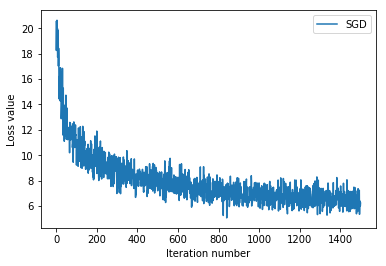

In [35]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

In [36]:
from ecbm4040.classifiers.basic_classifiers import Softmax

## Softmax + SGD
classifier = Softmax()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 5.778580
iteration 100 / 1500: loss 4.111795
iteration 200 / 1500: loss 3.620486
iteration 300 / 1500: loss 3.678909
iteration 400 / 1500: loss 3.361342
iteration 500 / 1500: loss 3.211012
iteration 600 / 1500: loss 3.002839
iteration 700 / 1500: loss 3.062069
iteration 800 / 1500: loss 3.122648
iteration 900 / 1500: loss 2.690415
iteration 1000 / 1500: loss 2.921718
iteration 1100 / 1500: loss 3.260845
iteration 1200 / 1500: loss 2.723960
iteration 1300 / 1500: loss 2.666162
iteration 1400 / 1500: loss 2.575495
training accuracy: 0.000000
validation accuracy: 0.000000


/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


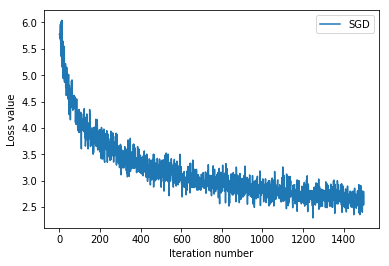

In [37]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()